In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_colwidth = 150
##
from datetime import datetime
import pytz
##
import re

In [2]:
def parse_str(x):
    """
    Returns the string delimited by two characters.

    Example:
        `>>> parse_str('[my string]')`
        `'my string'`
    """
    return x[1:-1]

def parse_datetime(x):
    '''
    Parses datetime with timezone formatted as:
        `[day/month/year:hour:minute:second zone]`

    Example:
        `>>> parse_datetime('13/Nov/2015:11:45:42 +0000')`
        `datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)`

    Due to problems parsing the timezone (`%z`) with `datetime.strptime`, the
    timezone will be obtained using the `pytz` library.
    '''
    dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

In [3]:
data = pd.read_csv(
    'weblogs/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})

In [4]:
data.head()

,ip,time,request,status,size,referer,user_agent
0,68.132.136.198,2020-04-20 06:28:16+00:00,POST /cgi-bin/mainfunction.cgi HTTP/1.1,301,592,NaN,XTC
1,37.187.75.16,2020-04-20 06:29:00+00:00,GET /wp-login.php HTTP/1.1,301,574,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
2,37.187.75.16,2020-04-20 06:29:02+00:00,GET /wp-login.php HTTP/1.1,404,4962,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
3,37.187.75.16,2020-04-20 06:29:06+00:00,GET /robots.txt HTTP/1.1,301,570,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
4,37.187.75.16,2020-04-20 06:29:08+00:00,GET /robots.txt HTTP/1.1,404,4538,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...


In [5]:
# get information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 7 columns):
ip            4776 non-null object
time          4776 non-null datetime64[ns, UTC]
request       4763 non-null object
status        4776 non-null int64
size          4776 non-null int64
referer       294 non-null object
user_agent    3918 non-null object
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 261.3+ KB


In [16]:
# check out just statuses

data['status'].head()

0    301
1    301
2    404
3    301
4    404
Name: status, dtype: int64

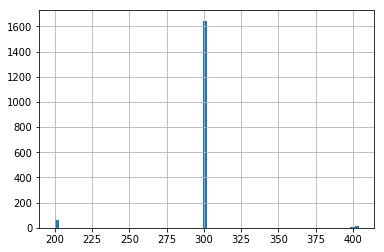

In [9]:
# what calls are most prominent (use histogram)
data['status'].hist(bins=70)

In [10]:
# Count how many values per status:
data['status'].value_counts()

301    1645
200      59
404      14
400       7
Name: status, dtype: int64

In [11]:
data['request'].head()

0               GET / HTTP/1.1
1               GET / HTTP/1.1
2               GET / HTTP/1.1
3     GET /robots.txt HTTP/1.1
4    GET /sitemap.xml HTTP/1.1
Name: request, dtype: object

In [6]:
data['request'].value_counts()

GET / HTTP/1.1                                                                                                                    992
GET / HTTP/1.0                                                                                                                    378
GET /robots.txt HTTP/1.1                                                                                                          256
\x16\x03\x01                                                                                                                      138
CONNECT 54.186.126.200:80 HTTP/1.0                                                                                                130
GET /wp-login.php HTTP/1.1                                                                                                        123
GET /latest/dynamic/instance-identity/document HTTP/1.1                                                                           104
GET /?feed=rss2 HTTP/1.1                                      

In [8]:
# what are the request returns?
data[['request','status']].head()

,request,status
0,POST /cgi-bin/mainfunction.cgi HTTP/1.1,301
1,GET /wp-login.php HTTP/1.1,301
2,GET /wp-login.php HTTP/1.1,404
3,GET /robots.txt HTTP/1.1,301
4,GET /robots.txt HTTP/1.1,404


In [12]:
data[data['status'] == 200][['request','status']].nunique()

request    63
status      1
dtype: int64

In [24]:
# narrow all the calls down to unique requests
uniquerequests = data['request'].unique().copy()

In [32]:
uniquerequests

array(['POST /cgi-bin/mainfunction.cgi HTTP/1.1',
       'GET /wp-login.php HTTP/1.1', 'GET /robots.txt HTTP/1.1', ...,
       'GET /websql/index.php HTTP/1.1',
       'GET /MySQLAdmin/index.php HTTP/1.1', 'Gh0st\\xad'], dtype=object)

Did any calls to MySQLAdmin get through?

In [38]:
data[data['request'] == 'GET /MySQLAdmin/index.php HTTP/1.1']

,ip,time,request,status,size,referer,user_agent
4699,193.112.212.143,2020-04-21 21:07:21+00:00,GET /MySQLAdmin/index.php HTTP/1.1,301,625,NaN,Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...


In [41]:
# find all rows where the data is in the most popular queries
data.loc[data['request'].isin(uniquerequests)]

,ip,time,request,status,size,referer,user_agent
0,68.132.136.198,2020-04-20 06:28:16+00:00,POST /cgi-bin/mainfunction.cgi HTTP/1.1,301,592,NaN,XTC
1,37.187.75.16,2020-04-20 06:29:00+00:00,GET /wp-login.php HTTP/1.1,301,574,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
2,37.187.75.16,2020-04-20 06:29:02+00:00,GET /wp-login.php HTTP/1.1,404,4962,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
3,37.187.75.16,2020-04-20 06:29:06+00:00,GET /robots.txt HTTP/1.1,301,570,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
4,37.187.75.16,2020-04-20 06:29:08+00:00,GET /robots.txt HTTP/1.1,404,4538,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
5,162.243.128.92,2020-04-20 06:36:19+00:00,GET / HTTP/1.1,200,4457,NaN,Mozilla/5.0 zgrab/0.x
6,42.230.207.98,2020-04-20 06:45:14+00:00,"GET /adv,/cgi-bin/weblogin.cgi?username=admin%...",301,721,NaN,Mozilla/5.0
7,162.241.244.109,2020-04-20 06:46:41+00:00,GET /dev/ HTTP/1.1,301,536,http://suckerpun.ch/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
8,162.241.244.109,2020-04-20 06:46:41+00:00,GET /dev/ HTTP/1.1,404,5413,http://suckerpun.ch/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
9,88.229.203.254,2020-04-20 06:46:51+00:00,GET / HTTP/1.1,301,530,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...


In [44]:
basicgets=['GET / HTTP/1.1','GET /robots.txt HTTP/1.1','GET / HTTP/1.0']

In [43]:
# How many of the popular unique requests got through? 
# this can't be right - clearly GET / HTTP/1.1 calls get through
data.loc[data['request'].isin(uniquerequests) & data['status'] == 200]

,ip,time,request,status,size,referer,user_agent


In [59]:
# filter with ~ anything that's a non-interesting request. that drops 1300
data[~data['request'].isin(basicgets)].shape

(3150, 7)

In [51]:
# Filter out basic GETs
df1 = data.loc[~data['request'].isin(basicgets)]

In [55]:
# unique IPs
uniqueip = df1['ip'].unique().copy()

In [62]:
df1.loc[data['ip'].isin(uniqueip)].head()

,ip,time,request,status,size,referer,user_agent
0,68.132.136.198,2020-04-20 06:28:16+00:00,POST /cgi-bin/mainfunction.cgi HTTP/1.1,301,592,NaN,XTC
1,37.187.75.16,2020-04-20 06:29:00+00:00,GET /wp-login.php HTTP/1.1,301,574,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
2,37.187.75.16,2020-04-20 06:29:02+00:00,GET /wp-login.php HTTP/1.1,404,4962,NaN,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...
6,42.230.207.98,2020-04-20 06:45:14+00:00,"GET /adv,/cgi-bin/weblogin.cgi?username=admin%...",301,721,NaN,Mozilla/5.0
7,162.241.244.109,2020-04-20 06:46:41+00:00,GET /dev/ HTTP/1.1,301,536,http://suckerpun.ch/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


In [64]:
useragents = df1['user_agent'].unique()

In [66]:
len(useragents)

86

In [77]:
botagents = [x for x in useragents if 'bot' or 'Bot' or 'AWS Security Scanner' in x]

In [78]:
df1.loc[~df1['user_agent'].isin(botagents)]

,ip,time,request,status,size,referer,user_agent,isbot


In [79]:
df1['isbot'] = df1['user_agent'].isin(botagents)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
df1.dropna(inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [89]:
df1[df1['status'] == 200]['user_agent']

322     Mozilla/5.0 (compatible; Let's Encrypt validat...
325     Mozilla/5.0 (compatible; Let's Encrypt validat...
328     Mozilla/5.0 (compatible; Let's Encrypt validat...
329     Mozilla/5.0 (compatible; Let's Encrypt validat...
330     Mozilla/5.0 (compatible; Let's Encrypt validat...
332     Mozilla/5.0 (compatible; Let's Encrypt validat...
338     Mozilla/5.0 (compatible; Let's Encrypt validat...
339     Mozilla/5.0 (compatible; Let's Encrypt validat...
340     Mozilla/5.0 (compatible; Let's Encrypt validat...
341     Mozilla/5.0 (compatible; Let's Encrypt validat...
342     Mozilla/5.0 (compatible; Let's Encrypt validat...
343     Mozilla/5.0 (compatible; Let's Encrypt validat...
568     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
570     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
572     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
720     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
721     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
724     Mozill

In [107]:
df1[df1['status'] == 200]['request']

322                                               GET /.well-known/acme-challenge/ivMHDaDGnzE5yFLUf5cj3MmnCsbEoEgDWzhcYlYlnCs HTTP/1.1
325                                               GET /.well-known/acme-challenge/arjSI5gOf0rmsovF9ov-6Hn-OgORdh2nqhWs4F5el48 HTTP/1.1
328                                               GET /.well-known/acme-challenge/ivMHDaDGnzE5yFLUf5cj3MmnCsbEoEgDWzhcYlYlnCs HTTP/1.1
329                                               GET /.well-known/acme-challenge/bdxwtIbO0NIv_gvvIoImmWW1rhB1DGr9E47OrP8dFFA HTTP/1.1
330                                               GET /.well-known/acme-challenge/arjSI5gOf0rmsovF9ov-6Hn-OgORdh2nqhWs4F5el48 HTTP/1.1
332                                               GET /.well-known/acme-challenge/bdxwtIbO0NIv_gvvIoImmWW1rhB1DGr9E47OrP8dFFA HTTP/1.1
338                                               GET /.well-known/acme-challenge/arjSI5gOf0rmsovF9ov-6Hn-OgORdh2nqhWs4F5el48 HTTP/1.1
339                                               GET /

In [105]:
pd.options.display.max_colwidth = 150

In [108]:
safeurl=['GET /goldgame','GET /counter','GET /numbergame','GET ecommerce/']

In [109]:
df1[df1['status'] == 200]['request'].shape

(59,)

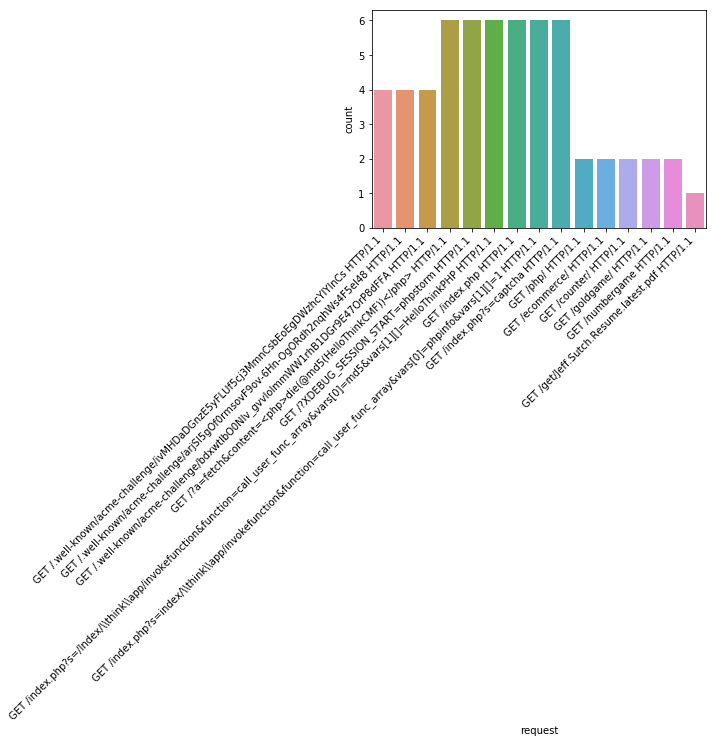

In [114]:
plt.xticks(rotation=45, ha='right')
sns.countplot(df1[df1['status'] == 200]['request'])